#  Imports and functions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import random

from sklearn.linear_model import Lasso, LinearRegression as LR
from sklearn.linear_model import Ridge

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

from sklearn.preprocessing import PolynomialFeatures as PF
from sklearn.preprocessing import StandardScaler as SS

from sklearn.model_selection import train_test_split as tts

from IPython.display import clear_output
from datetime import datetime as dt

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

from scipy import stats
from scipy.stats import ks_2samp
from scipy.stats import kstest

from scipy.stats import wasserstein_distance


In [2]:

def GetColors(N, cmap_name='rainbow'):
    from matplotlib.cm import get_cmap
    import numpy as np

    cmap = get_cmap(name=cmap_name)
    n = np.linspace(0,1,N)
    return cmap(n)

def PlotGroups(points, groups, colors):
    import matplotlib.pyplot as plt

    plt.figure(figsize=(6,6))

    for i, yi in enumerate(np.unique(groups)):
        idx = (groups == yi)
        plt.scatter(points[idx, 0], points[idx, 1],
                    alpha=0.5, ec='k', color=colors[i], label = yi)
    plt.axis('equal')
    plt.legend(loc='center left', bbox_to_anchor=[1, 0.5])
    #plt.show()
    return

def CompareClasses(actual, predicted, names=None):
    classes = pd.DataFrame(columns=['Predicted','Actual'])
    classes['Predicted'] = predicted
    classes['Actual'] = actual

    conf_mat = pd.crosstab(columns=classes['Predicted'],
                       index = classes['Actual'])
    if names != None:
        conf_mat.columns = names
        conf_mat.index = names

    conf_mat.columns.name = 'Predicted'
    conf_mat.index.name = 'Actual'

    accuracy = sum(predicted==actual)/len(actual)

    return conf_mat, accuracy

def DoKFold(model, X, y, k, scaler=None):
    from sklearn.model_selection import KFold
    import pandas as pd

    kf = KFold(n_splits=k, shuffle=True)

    if type(X) == pd.core.frame.DataFrame:
        X = X.values

    training_scores=[]
    testing_scores=[]

    for idxTrain, idxTest in kf.split(X):
        Xtrain = X[idxTrain,:]
        Xtest = X[idxTest,:]
        ytrain = y[idxTrain]
        ytest = y[idxTest]

        if scaler != None:
            # For standardization:
            # Fit/transform on training data
            Xtrain = scaler.fit_transform(Xtrain)
            #
            # Only transform (i.e, don't refit) on test data
            Xtest = scaler.transform(Xtest)

        model.fit(Xtrain,ytrain)

        training_scores.append(model.score(Xtrain,ytrain))
        testing_scores.append(model.score(Xtest,ytest))

    return training_scores, testing_scores

def plot_train_test(train, test, width, x_lab = None, y_lab = 'Mean Accuracy'):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10,8))
    plt.plot(width, train, '-kx')
    plt.plot(width, test, '-rx')
    plt.legend()
    plt.xlabel(x_lab)
    plt.ylabel(y_lab)
    plt.show()


# Model simulation code


In [3]:
from math import sqrt
from array import *
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime as dt
import pandas as pd

In [4]:
def sutherland(T):
    """
    This function uses Sutherlands law to return dynamic viscosity for air as a function of temperature.
    Source: White, Viscous Fluid Flow, 3rd Edition Section 1-3.7

    Inputs
    ------
    T : float
        Temperature of air [K]

    Outputs
    -------
    mu : float
        Dynamic viscosity of air [N*s/m^2]

    Other Parameters
    ----------------
    T_ref: float
        Reference temperature of air [K]
    mu_ref: float
        Reference dynamic viscosity of air [N*s/m^2]
    S: float
        Sutherland constant for air [K]
    """

    # Reference Conditions for Air (From White Section 1-3.7 Table 1-2)
    T_ref = 273.0       # [K]
    mu_ref = 1.716e-5   # [N*s/m^2]
    S = 111.0           # [K]

    # Sutherland's Formula (White Section 1-3.7) (Note White uses T_0, mu_0 instead of T_ref, mu_ref)
    mu = mu_ref * ( (T/T_ref)**(3.0/2.0) * (T_ref + S)/(T + S) ) # [N*s/m^2]



    k_0 = 0.0241
    T_0 = 273 # [K]
    S_k = 194


    k = k_0 * ( (T/T_0)**(3.0/2.0) * (T_0 + S_k)/(T + S_k) ) # [W/(m*K)]

    return [mu, k]


In [5]:
def q_wall_fun(Tw, state, otherStuff):

    emissivity = otherStuff[0]
    M_inf = otherStuff[1]       # Freestream Mach number
    p_inf = otherStuff[2]       # Freestream pressure [Pa]
    T_inf = otherStuff[3]       # Freestream temperature [K]
    fudge_factor = otherStuff[4]

    edgeFlow = flowState()
    edgeFlow.fillMPT(M_inf, p_inf, T_inf)
    edgeFlow.state = state
    #edgeFlow.state = 'lam'
    #edgeFlow.state = 'turb'

    L = 1

    #Tw = 300      # Wall temperature [K]

    #f = lambda x: qwFun(x, edgeFlow, L, fudge_factor) - qradFun(x,emissivity)
    #Tw = bisection(f,100,2000,100)

    [qconv, Rex, Nu, Taw] = qwFun(Tw, edgeFlow, L, fudge_factor)
    qrad = qradFun(Tw,emissivity)

    #print("Tw = ", Tw)
    #print("qconv = ", qconv)
    #print("qrad = ", qrad)
    #print("Rex = ", Rex)
    #print("Nu = ", Nu)
    #print("Taw = ", Taw)

    qWall = qconv - qrad

 #   print("===")
 #   print("Tw = ", Tw)
 #   print("qWall = ", qWall)
 #   print("===")

    return qWall


def qradFun(Tw,emissivity):
    #emissivity = 0.8
    sigma = 5.6703e-8
    qrad = emissivity * sigma * Tw**4
    return qrad


def qwFun(Tw, edge, x, fudge_factor):
    """
    This function computes the convective heat flux for a flat plate.

    Inputs
    ------
    Tw : float
        Wall temperature [K]
    edge : flowState
        flowState at the edge of the boundary layer
    x : float
        Running length along the surface [m]

    Outputs
    -------
    qw : float
        Convective heat flux at the wall [W/m^2]
    """

    r = recoveryFactorFun(edge.Pr, edge.state)

    Taw = adiabaticWallTempFun(r, edge.T, edge.T0)

    Rex_e = edge.rho * edge.u * x / edge.mu



    if edge.state == 'lam':

        #T_star = edge.T * (0.5 + 0.039 * edge.M**2.0 + 0.5 * (Tw / edge.T))
        #CR_star = (T_star / edge.T)**(-1.0/3.0)
        #Rex_e = edge.rho * edge.u * x / edge.mu
        #cf = 0.664 * sqrt(CR_star) / sqrt(Rex_e)
        #ch = cf / (2.0 * edge.Pr**(2.0/3.0))
        #qw = ch * edge.rho * edge.u * edge.cp * (Taw - Tw)

        a = 0.332 # 0.453
        Nu = a * Rex_e**0.5*edge.Pr**(1.0/3.0)
        h = Nu*edge.k/x
        qw = h * (Taw - Tw)
        qw = qw * fudge_factor

    elif edge.state == 'turb':
        Nu = 0.0296 * Rex_e**0.8 * edge.Pr**0.6
        h = Nu*edge.k/x
        qw = h * (Taw - Tw)
        qw = qw * fudge_factor
    else:
        print('error')




    return [qw, Rex_e, Nu, Taw]

def edgeStateFun(M_inf, p_inf, T_inf):
    """
    This function computes a state vector of the flow properties at the edge of the boundary layer for a flat plate given the freestream conditions.

    Inputs
    ------
    M_inf : float
        Freestream Mach number

    p_inf : float
        Freestream pressure [Pa]

    T_inf : float
        Freestream temperature [K]

    Outputs
    ------
    edge : flowState
        flowState at the edge of the boundary layer
    """

    edge = flowState()

    edge.M = M_inf
    edge.p = p_inf
    edge.T = T_inf

    gamma_e = 1.4
    edge.cp = 1006.0 # [J/kg*K]
    R_e = 287.0 # [J/kg*K]

    a_e = sqrt(gamma_e * R_e * edge.T) # [m/s]
    edge.u = edge.M * a_e # [m/s]
    edge.rho = edge.p / (R_e * edge.T) # [kg/m^3]

    edge.mu = sutherland(edge.T)

    edge.T0 = edge.T + edge.u**2.0 / (2.0 * edge.cp)


    return edge

def recoveryFactorFun(Pr, flowState):
    """
    This function returns the recovery factor given the Prandtl number and the flow state (either laminar or turbulent).
    White, Viscous Fluid Flow, 3rd Edition Sections 7-3.1 and 7-8.3

    Inputs
    ------
    Pr : float
        Prandtl number

    flowState : str
        State of the flow: 'lam' for laminar or 'turb' for turbulent

    Outputs
    -------
    r : float
        Recovery factor
    """


    if flowState == 'lam':
        r = Pr**(0.5)   # White, Eq 7-37a in Section 7-3.1
    elif flowState == 'turb':
        r = Pr**(1.0/3.0) # White, Eq 7-136 in Section 7-8.3
    else:
        print('error')

    return r

def adiabaticWallTempFun(r, T_e, T0_e):
    """
    This function computes the adiabatic wall temperature given the recovery factor and static and total temperatures at the edge of the boundary layer.
    Source: White, Viscous Fluid Flow, 3rd Edition, Section 7-1.2

    Inputs
    ------
    r : float
        Recovery factor
    T_e : float
        Temperatures at the edge of the boundary layer [K]
    T0_e : float
        Total temperatures at the edge of the boundary layer [K]

    Outputs
    -------
    Taw : float
        Adiabatic wall temperature [K]
    """

    Taw = T_e + r * (T0_e - T_e) # White, Eq 7-16

    return Taw

class flowState:
    """
    This class represents the state variables at a point in a flow field.

    Attributes
    ----------
    M : float
        Mach number
    p : float
        Pressure [Pa]
    T : float
        Temperature [K]
    rho : float
        Density [kg/m^3]
    u : float
        Velocity magnitude [m/s]
    a : float
        Speed of sound [m/s]
    T0 : float
        Total temperature [K]
    p0 : float
        Total pressure [Pa]
    gamma : float
        Ratio of specific heats
    R : float
        Gas constant for air [J/kg*K]
    cp : float
        Specific heat at constant pressure [J/kg*K]
    mu : float
        Dynamic viscosity [N*s/m^2]
    Pr : float
        Prandtl number
    state : str
        State of the flow: 'lam' for laminar or 'turb' for turbulent

    Methods
    -------
    fillMPT(M, p, T)
        Fills the flow state using M, p, and T
    """

    def __init__(self):
        self.M      = []
        self.p      = []
        self.T      = []
        self.rho    = []
        self.u      = []
        self.a      = []
        self.q      = []
        self.p0     = []
        self.T0     = []
        self.gamma  = 1.4
        self.R      = 287.0     # [J/kg*K]
        self.cp     = 1004.5    # [J/kg*K]
        self.mu     = []
        self.k      = []
        self.Pr     = 0.72
        self.state  = []

    def fillMPT(self, M, p, T):
        """
        This method uses Mach, pressure, and temperature, along with the pre-defined thermodynamic states variables (gamma and R), to fill in most of the remaining flow state variables.
        """

        self.M = M
        self.p = p
        self.T = T

        self.a = sqrt(self.gamma * self.R * T) # [m/s]
        self.u = M * self.a # [m/s]
        self.rho = p / (self.R * T) # [kg/m^3]

        self.q = 0.5 * self.rho * self.u**2 #[Pa]

        [self.mu, self.k] = sutherland(T)

        self.T0 = T * (1.0 + 0.5*(self.gamma-1)*M**2)
        self.p0 = p * (1.0 + 0.5*(self.gamma-1)*M**2)**(self.gamma/(self.gamma-1))

In [6]:
def conductionFun(x_input, state, t_final):

    h_tile  = x_input[0]
    h_Ti    = x_input[1]

    rho_tile    = x_input[2]
    rho_Ti      = x_input[3]
    cp_tile     = x_input[4]
    cp_Ti       = x_input[5]
    k_tile      = x_input[6]
    k_Ti        = x_input[7]

    otherInputs = x_input[8:13]

    tps = TPSElement()

    #--- Outer BC ---
    #tps.OuterBCType = "fixedTemp"
    tps.OuterBCType = "fixedQ"
    #tps.TOuter = 600.0 # [K]
    #tps.qOuter = 141172.0 # [W/(m^2)]

    #--- Outer BC ---
    tps.InnerBCType = "insulated"
    tps.qInner = 0.0 # [W/(m^2)]

    #--- Initial Temperature ---
    tps.T0 = 300 # [K]

    #--- Define TPS Layrs ---
    #tps.layerThickness      = [0.0001, 0.007, 0.0001, 4*0.0254, 0.00015] #[m]
    #tps.rhoList             = [7117, 132, 7117, 96, 4437]                #[kg/m^3]
    #tps.cpList              = [625, 625, 625, 1150, 700]                 #[J/kg*K]
    #tps.kList               = [18, 0.35, 18, 0.05, 13]                   #[W/mK]
    #tps.nGridCellsPerLayer  = [4, 4, 4, 4, 4]

    tps.layerThickness      = [h_tile, h_Ti]   #[m]
    tps.rhoList             = [rho_tile, rho_Ti]           #[kg/m^3]
    tps.cpList              = [cp_tile, cp_Ti]            #[J/kg*K]
    tps.kList               = [k_tile, k_Ti]          #[W/mK]
    tps.nGridCellsPerLayer  = [50, 20]

    #tps.layerThickness      = [0.65*0.0254]   #[m]
    #tps.rhoList             = [144]           #[kg/m^3]
    #tps.cpList              = [628]            #[J/kg*K]
    #tps.kList               = [0.126]          #[W/mK]
    #tps.nGridCellsPerLayer  = [400]



    #--- Initialize the TPS Element ---
    tps.initializeTPS()
    tps.qOuter = q_wall_fun(tps.T[0], state, otherInputs)


#    print("==================================")
#    print("   time = ", tps.time)
#    print("==================================")
#    print("nLayers              = ", tps.nLayers)
#    print("nGridCellsPerLayer   = ", tps.nGridCellsPerLayer)
#    print("nGridCells           = ", tps.nGridCells)
#    print("delta_yPerLayer      = ", tps.delta_yPerLayer)
#    print("T[0]                 = ", tps.T[0])
#    print("T[end]               = ", tps.T[-1])
#    print("qOuter               = ", tps.qOuter)
    #print("delta_y              = ", tps.delta_y)
    #print("rho                  = ", tps.rho)
    #print("cp                   = ", tps.cp)
    #print("k                    = ", tps.k)
    #print("M = ")
    #print(tps.M)
    #print("T_RHS = ")
    #print(tps.T_RHS)

    delta_t = 0.1
    #tps.advance(delta_t)

    #t_final = 600

    for i in range(int(t_final/delta_t)):
        tps.advance(delta_t)
        tps.qOuter = q_wall_fun(tps.T[0], state, otherInputs)
        #print("Twall        = ", tps.T[0])

#    print(" ")
#    print("==================================")
#    print("   time = ", tps.time)
#    print("==================================")
#    print("qOuter       = ", tps.qOuter)
#    print("Twall        = ", tps.T[0])
#    print("T_Ti_outer   = ", tps.T[tps.nGridCellsPerLayer[0]])
#    print("T_Ti_inner   = ", tps.T[-1])
    #print("T = ", tps.T)

    return tps.T[tps.nGridCellsPerLayer[0]]

class TPSElement:
    """

    """

    def __init__(self):
        self.OuterBCType        = []
        self.InnerBCType        = []
        self.TOuter             = []
        self.TInner             = []
        self.qOuter             = []
        self.qInner             = []

        self.t0                 = 0.0       # Initial time
        self.time               = self.t0   # Time

        self.T0                 = []    # Initial temperature
        self.T                  = []    # Temperature

        self.y                  = []
        self.delta_y            = []
        self.delta_yPerLayer    = []

        self.nGridCellsPerLayer = []
        self.nGridCells         = []
        self.nLayers            = []
        self.layerThickness     = []

        self.rhoList            = []
        self.cpList             = []
        self.kList              = []

        self.rho                = []
        self.cp                 = []
        self.k                  = []

        self.M                  = []
        self.T_RHS              = []

    def initializeTPS(self):
        self.nLayers = len(self.layerThickness)

        self.nGridCells = 0
        for i in range(self.nLayers):
            self.nGridCells = self.nGridCells + self.nGridCellsPerLayer[i]

        self.delta_yPerLayer = [0] * self.nLayers
        for i in range(self.nLayers):
            self.delta_yPerLayer[i] = self.layerThickness[i] / self.nGridCellsPerLayer[i]

        self.T = [self.T0] * self.nGridCells

        self.delta_y = [0] * self.nGridCells
        self.rho     = [0] * self.nGridCells
        self.cp      = [0] * self.nGridCells
        self.k       = [0] * self.nGridCells

        counter = 0
        for i in range(self.nLayers):
            for j in range(self.nGridCellsPerLayer[i]):
                self.delta_y[counter]   = self.delta_yPerLayer[i]
                self.rho[counter]       = self.rhoList[i]
                self.cp[counter]        = self.cpList[i]
                self.k[counter]         = self.kList[i]
                counter = counter + 1

        self.M = np.empty(shape=(self.nGridCells,self.nGridCells))
        self.M.fill(0)

        self.T_RHS = np.empty(shape=(self.nGridCells,1))
        self.T_RHS.fill(0)

    def advance(self, delta_t):
        self.time = self.time + delta_t


        self.M[0][0] = -self.B(1)-self.A(0,delta_t)
        self.M[0][1] = self.B(1)
        self.T_RHS[0] = -self.A(0,delta_t) * self.T[0] - self.qOuter

        for i in range(1,self.nGridCells-1):
            self.M[i][i-1]   = self.B(i)
            self.M[i][i]     = -self.B(i) - self.B(i+1) - self.A(i,delta_t)
            self.M[i][i+1]   = self.B(i+1)
            self.T_RHS[i]    = -self.A(i,delta_t) * self.T[i]

        i_end = self.nGridCells - 1
        self.M[-1][-2] = self.B(i_end)
        self.M[-1][-1] = -self.B(i_end) - self.A(i_end,delta_t)
        self.T_RHS[-1] = -self.A(i_end,delta_t) * self.T[i_end] + self.qInner

        T_LHS = np.matmul(np.linalg.inv(self.M), self.T_RHS)

        self.T = list(T_LHS.flatten())

    def A(self, i, delta_t):

        A = self.rho[i] * self.cp[i] * self.delta_y[i] / delta_t

        return A

    def B(self, i):

        delta_y_avg = 0.5 * (self.delta_y[i] + self.delta_y[i-1])
        k_avg = (self.delta_y[i] * self.k[i] + self.delta_y[i-1] * self.k[i-1]) / (2.0 * delta_y_avg)

        B = k_avg / delta_y_avg

        return B


In [7]:
t_final     = 60    # [sec]

h_tile      = 0.0254     # [m]
h_Ti        = 0.00015    # [m]

rho_tile    = 144   # [kg/m^3]
rho_Ti      = 4540  # [kg/m^3]
cp_tile     = 628   # [J/kg*K]
cp_Ti       = 460   # [J/kg*K]
k_tile      = 0.126 # [W/mK]
k_Ti        = 7.1   # [W/mK]

emissivity  = 0.8

M_inf = 5.0     # Freestream Mach number
p_inf = 2736.0  # Freestream pressure [Pa]
T_inf = 284.0   # Freestream temperature [K]

fudge_factor = 1.0

x_input = [h_tile, h_Ti, rho_tile, rho_Ti, cp_tile, cp_Ti, k_tile, k_Ti,emissivity, M_inf, p_inf, T_inf, fudge_factor]

In [8]:
def run_model(x_input,t_final):
    T_Ti = conductionFun(x_input, 'turb', t_final)

    return T_Ti

# Data simulator function

In [9]:
def simulate_data_set(prop_var = 0.1, N = 5, dims_to_use = []):
    overall_start = dt.now()
    import numpy as np
    import random
    from IPython.display import clear_output

    sim_input = []
    #Baseline values for each variable as a dict

    baseline = {'t_final': [60, 60*prop_var],  # [sec]
                    'h_tile': [.0254, .0254*prop_var],    # [m]
                    'h_Ti': [0.00015, 0.00015*prop_var],    # [m]
                    'rho_tile': [144, 144*prop_var],   # [kg/m^3]
                    'rho_Ti': [4540, 4540*prop_var],  # [kg/m^3]
                    'cp_tile': [628, 628*prop_var],   # [J/kg*K]
                    'cp_Ti': [460, 460*prop_var],   # [J/kg*K]
                    'k_tile': [0.126, 0.126*prop_var], # [W/mK]
                    'k_Ti': [7.1, 7.1*prop_var],   # [W/mK]
                    'emissivity': [0.8, 0.8*prop_var],
                    'M_inf': [5.0, 5.0*prop_var],     # Freestream Mach number
                    'p_inf': [2736.0, 2736.0*prop_var],  # Freestream pressure [Pa]
                    'T_inf': [284.0, 284*prop_var],   # Freestream temperature [K]
                    'fudge_factor': [1.0, 1.0*prop_var]
                    }

    sim_data = pd.DataFrame()

    for k,v in baseline.items():
      column = []
      for n in range(N):
        if k in dims_to_use or dims_to_use == []:
          column.append(random.gauss(v[0], v[1]))
        else:
          column.append(v[0])
      sim_data[k] = column

    print('values calculated, moving to simulations')

    simulator_values = []
    for i in range(len(sim_data)):
      clear_output()
      print('values calculated, moving to simulations')
      print('simulator iteration', i)
      print('Runtime:', dt.now()-overall_start)
      values = sim_data.loc[i]
      #print(values)
      #print(run_model(values[1:], values[0]))
      simulator_values.append(run_model(values[1:],values[0]))

    sim_data['Final_temp'] = simulator_values

    #clear_output()
    print('Runtime:', dt.now()-overall_start)


    return(sim_data)





### Testing on only t_final

In [10]:
#MC_simulated_data = simulate_data_set(N = 1000, dims_to_use = ['t_final'])
lasso_training_set = simulate_data_set(N = 450, dims_to_use = ['t_final'])
lasso_validation_set = simulate_data_set(N = 550, dims_to_use = ['t_final'])

values calculated, moving to simulations
simulator iteration 549
Runtime: 0:08:22.848195
Runtime: 0:08:23.703760


In [11]:
gpr_training_set = simulate_data_set(N = 450, dims_to_use = ['h_tile'])
gpr_validation_set = simulate_data_set(N = 550, dims_to_use = ['h_tile'])

values calculated, moving to simulations
simulator iteration 549
Runtime: 0:08:17.728527
Runtime: 0:08:18.507668


In [13]:
dimensions = lasso_training_set.drop('Final_temp', axis = 1)
target = lasso_training_set['Final_temp']

ss = SS()

dimensions_st = ss.fit_transform(dimensions)

In [14]:
dimensions = gpr_training_set.drop('Final_temp', axis = 1)
target = gpr_training_set['Final_temp']

ss = SS()

dimensions_st = ss.fit_transform(dimensions)

In [15]:
training_scores = []
testing_scores = []
k = 100
a_range = np.linspace(0.01, 0.5, 100)

for a in a_range:
    clear_output()
    print('Currently testing alpha =', a)
    las = Lasso(alpha=a)
    tr,te = DoKFold(las,dimensions_st, target,k)

    training_scores.append(tr)
    testing_scores.append(te)

mean_tr = []
mean_te = []
for score_set in training_scores:
    mean_tr.append(np.mean(score_set))
for te_set in testing_scores:
    mean_te.append(np.mean(te_set))



Currently testing alpha = 0.5


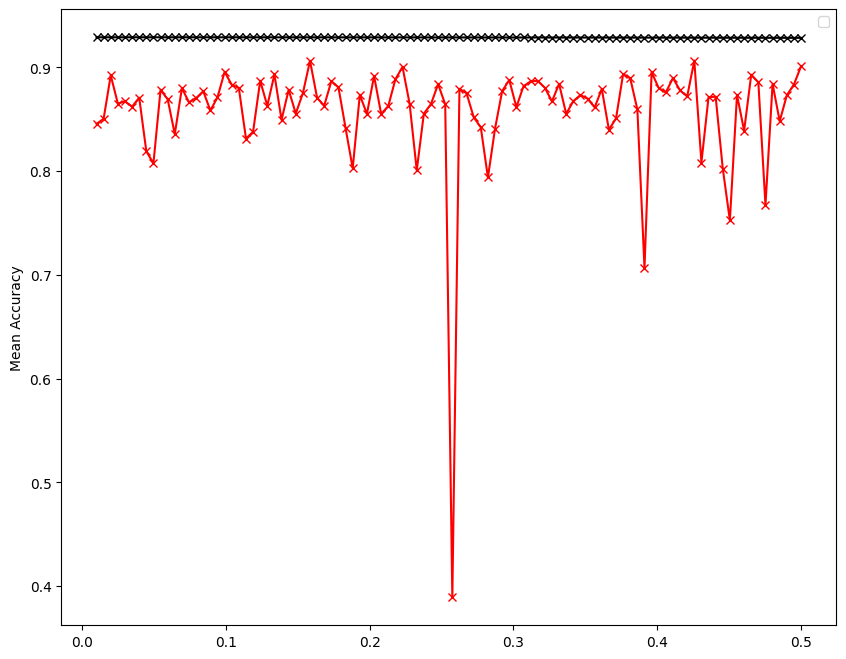

In [16]:
plot_train_test(mean_tr, mean_te, a_range)

In [17]:
best_alpha = a_range[np.argmax(mean_te)]
tuned_las = Lasso(alpha = best_alpha)
best_alpha

0.4257575757575757

In [18]:
tuned_las.fit(dimensions_st, target)
tuned_las.score(dimensions_st, target)

0.9285828315427196

In [20]:
from sklearn.gaussian_process import GaussianProcessRegressor

constant = 1

kernel = constant * RBF(length_scale= 1.0, length_scale_bounds=(1e-3, 1e3))

gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, normalize_y = True)

gpr.fit(dimensions_st, target)

GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=1),
                         n_restarts_optimizer=9, normalize_y=True)

In [22]:
def use_surrogate_model(model, volume, dims_to_use = [], prop_var = 0.1):
  overall_start = dt.now()
  import random
  from sklearn.preprocessing import StandardScaler as SS
  from IPython.display import clear_output

  sim_input = []
  #Baseline values for each variable as a dict

  baseline = {'t_final': [60, 60*prop_var],  # [sec]
                  'h_tile': [.0254, .0254*prop_var],    # [m]
                  'h_Ti': [0.00015, 0.00015*prop_var],    # [m]
                  'rho_tile': [144, 144*prop_var],   # [kg/m^3]
                  'rho_Ti': [4540, 4540*prop_var],  # [kg/m^3]
                  'cp_tile': [628, 628*prop_var],   # [J/kg*K]
                  'cp_Ti': [460, 460*prop_var],   # [J/kg*K]
                  'k_tile': [0.126, 0.126*prop_var], # [W/mK]
                  'k_Ti': [7.1, 7.1*prop_var],   # [W/mK]
                  'emissivity': [0.8, 0.8*prop_var],
                  'M_inf': [5.0, 5.0*prop_var],     # Freestream Mach number
                  'p_inf': [2736.0, 2736.0*prop_var],  # Freestream pressure [Pa]
                  'T_inf': [284.0, 284*prop_var],   # Freestream temperature [K]
                  'fudge_factor': [1.0, 1.0*prop_var]
                  }

  sim_data = pd.DataFrame()

  for k,v in baseline.items():
    column = []
    for n in range(volume):
      if k in dims_to_use:
        column.append(random.gauss(v[0], v[1]))
      else:
        column.append(v[0])
    sim_data[k] = column

  print('values calculated, moving to simulations')

  ss = SS()
  st_data = ss.fit_transform(sim_data)

  preds = model.predict(st_data)

  sim_data['Final_temp'] = preds

  print('Simulation complete')


  return(sim_data)

In [23]:
new_data = use_surrogate_model(model = gpr, volume = 550, dims_to_use = ['h_tile'])

values calculated, moving to simulations
Simulation complete


In [24]:
new_data

,t_final,h_tile,h_Ti,rho_tile,rho_Ti,cp_tile,cp_Ti,k_tile,k_Ti,emissivity,M_inf,p_inf,T_inf,fudge_factor,Final_temp
0,60,0.031858,0.00015,144,4540,628,460,0.126,7.1,0.8,5.0,2736.0,284.0,1.0,311.773403
1,60,0.025441,0.00015,144,4540,628,460,0.126,7.1,0.8,5.0,2736.0,284.0,1.0,342.471946
2,60,0.023052,0.00015,144,4540,628,460,0.126,7.1,0.8,5.0,2736.0,284.0,1.0,365.132244
3,60,0.023287,0.00015,144,4540,628,460,0.126,7.1,0.8,5.0,2736.0,284.0,1.0,362.521825
4,60,0.028073,0.00015,144,4540,628,460,0.126,7.1,0.8,5.0,2736.0,284.0,1.0,325.696056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545,60,0.030179,0.00015,144,4540,628,460,0.126,7.1,0.8,5.0,2736.0,284.0,1.0,316.787099
546,60,0.027937,0.00015,144,4540,628,460,0.126,7.1,0.8,5.0,2736.0,284.0,1.0,326.395343
547,60,0.025123,0.00015,144,4540,628,460,0.126,7.1,0.8,5.0,2736.0,284.0,1.0,345.030308
548,60,0.027297,0.00015,144,4540,628,460,0.126,7.1,0.8,5.0,2736.0,284.0,1.0,329.901007


In [25]:
#lasso_training_set = lasso_training_set.rename(columns = {'simulator_values': 'Final_temp'})
#new_data = new_data.rename(columns = {'Model_predictions': 'Final_temp'})

In [26]:
Validation_dims = lasso_validation_set.drop('Final_temp', axis = 1)
validation_target = lasso_validation_set['Final_temp']

ss = SS()

Validation_dims_st = ss.fit_transform(Validation_dims)


In [27]:
Validation_dims = gpr_validation_set.drop('Final_temp', axis = 1)
validation_target = gpr_validation_set['Final_temp']

ss = SS()

Validation_dims_st = ss.fit_transform(Validation_dims)


In [28]:
validation_preds = tuned_las.predict(Validation_dims_st)


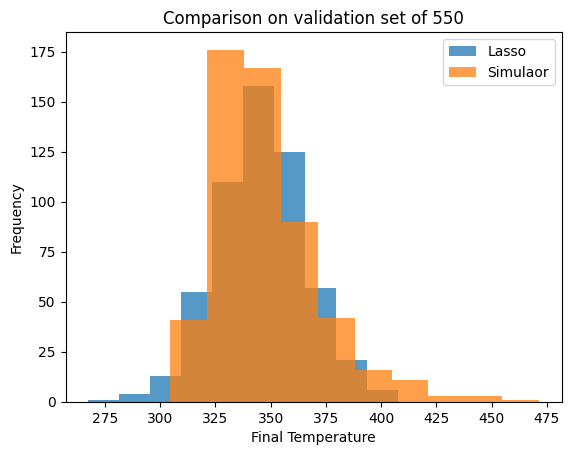

In [29]:
plt.hist(validation_preds, alpha = 0.75)
plt.hist(validation_target, alpha = 0.75)

plt.xlabel('Final Temperature')
plt.ylabel('Frequency')


plt.title('Comparison on validation set of 550')
#plt.figtext('Distributions of final temperatures from a validation set of 550 and the predicted values of those 550 temperatures')

plt.legend(['Lasso', 'Simulaor'])

In [33]:
ks_2samp(validation_preds, validation_target)

KstestResult(statistic=0.06727272727272728, pvalue=0.16594191052452847, statistic_location=342.7923442305104, statistic_sign=-1)

In [34]:
wasserstein_distance(validation_preds, validation_target)

4.225033837061326

### Testing on all dimensions

In [ ]:
tr = simulate_data_set(N = 450, dims_to_use = [])
te = simulate_data_set(N = 550, dims_to_use = [])

In [ ]:
plt.hist(tr['Final_temp'], alpha = 0.5)
plt.hist(te['Final_temp'], alpha = 0.5)

In [ ]:
tr_X = tr.drop('Final_temp', axis = 1)
tr_y = tr['Final_temp']

ss_tr = SS()
tr_X_st = ss_tr.fit_transform(tr_X)


te_X = te.drop('Final_temp', axis = 1)
te_y = te['Final_temp']

ss_te = SS()
te_X_st = ss_tr.fit_transform(te_X)

In [ ]:
training_scores = []
testing_scores = []
k = 100
a_range = np.linspace(0.01, 0.5, 100)

for a in a_range:
    clear_output()
    print('Currently testing alpha =', a)
    las = Lasso(alpha=a)
    tr,te = DoKFold(las,tr_X_st, tr_y,k)

    training_scores.append(tr)
    testing_scores.append(te)

mean_tr = []
mean_te = []
for score_set in training_scores:
    mean_tr.append(np.mean(score_set))
for te_set in testing_scores:
    mean_te.append(np.mean(te_set))



In [ ]:
plot_train_test(mean_tr, mean_te, a_range)

In [ ]:
best_alpha = a_range[np.argmax(mean_te)]
tuned_las = Lasso(alpha = best_alpha)
best_alpha

In [ ]:
tuned_las.fit(tr_X_st, tr_y)
tuned_las.score(tr_X_st, tr_y)

In [ ]:
val_preds = tuned_las.predict(te_X_st)

In [ ]:
print(mean_squared_error(te_y, val_preds))
print(mean_absolute_error(te_y, val_preds))
print(r2_score(te_y, val_preds))


In [ ]:
print(np.mean(val_preds) - np.mean(te_y))
print(np.std(val_preds) - np.std(te_y))

In [ ]:
plt.hist(val_preds, alpha = 0.75)
plt.hist(te_y, alpha = 0.25)
plt.legend(['predictions', 'truth'])

#### This is not great, MSE is much higher than expected
- Assumption: This is due to lack of normality in target temp
  - Solution: Box cox or maybe gamma regression

In [ ]:
bc_tr_y, bc_lambda = stats.boxcox(tr_y)

In [ ]:
print(bc_lambda)
plt.hist(bc_tr_y)
plt.show()

In [ ]:
training_scores = []
testing_scores = []
k = 100
a_range = np.linspace(0.01, 0.5, 100)

for a in a_range:
    clear_output()
    print('Currently testing alpha =', a)
    las = Lasso(alpha=a)
    tr,te = DoKFold(las,tr_X_st, bc_tr_y,k)

    training_scores.append(tr)
    testing_scores.append(te)

mean_tr = []
mean_te = []
for score_set in training_scores:
    mean_tr.append(np.mean(score_set))
for te_set in testing_scores:
    mean_te.append(np.mean(te_set))



In [ ]:
plot_train_test(mean_tr, mean_te, a_range)